# House price 
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


import warnings
warnings.filterwarnings('ignore')


In [373]:
# Load data
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')
print(df_train.shape,df_test.shape)

(1460, 81) (1459, 80)


In [374]:
# column information
print(df_train.columns)
df_train.columns.shape

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

(81,)

We have 81 columns in the data. Entire column description can be found in ../data/raw/data_dexcrption.txt

The target variable here is 'SalePrice' which is numeric variable.

In [375]:
df_train['Id'].head()

0    1
1    2
2    3
3    4
4    5
Name: Id, dtype: int64

ID column doesn't add any information so it should be dropped from further analysis.

In [376]:
df_train.drop(['Id'], axis=1, inplace=True)

In [377]:
# Categorical data
print(df_train.dtypes[df_train.dtypes=='object'].shape)
df_train.dtypes[df_train.dtypes=='object']

(43,)


MSZoning         object
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
MiscFeature      object
SaleType        

We have 43 category features out of 80 entire features. (without ID column)

In [378]:
# Numerical data
print(df_train.dtypes[df_train.dtypes!='object'].shape)
df_train.dtypes[df_train.dtypes!='object']

(37,)


MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

We have 37 numerical features out of 80 entire features. (without ID column)

## SalePrice

SalePrice is a dependent variable we should predict. Let's see this first. 

In [379]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The average is 180921 with 79442 for standard deviation. The median (163000) is smaller than std, so we can expect that SalePrice might be right skewed. Then, let's check this with histogram. 

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

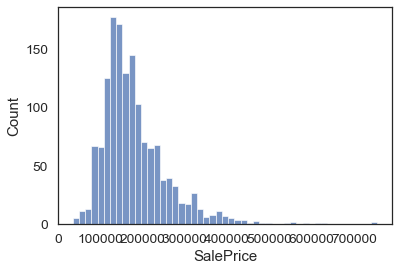

In [380]:
sns.histplot(data=df_train, x='SalePrice')

As expected, the SalePrice is right skewed. We need to convert this to normal distribution since regression models usually doesn't work well with dependent variable that is non-normally distributed. We'll do that later. 

### Relationship among important features with SalePrice :

Let's look around features expected to have important relationship with SalePrice. <br>

When roughly thinking about the things that determine houseprices, the following 4 features seem important. <br>

1) 'GrLivArea' (Above grade (ground) living area square feet) <br>
2) 'TotalBsmtSF' (Total square feet of basement area) <br>
3) 'OverallQual' (Rates the overall material and finish of the house) <br>
4) 'YearBuilt'.

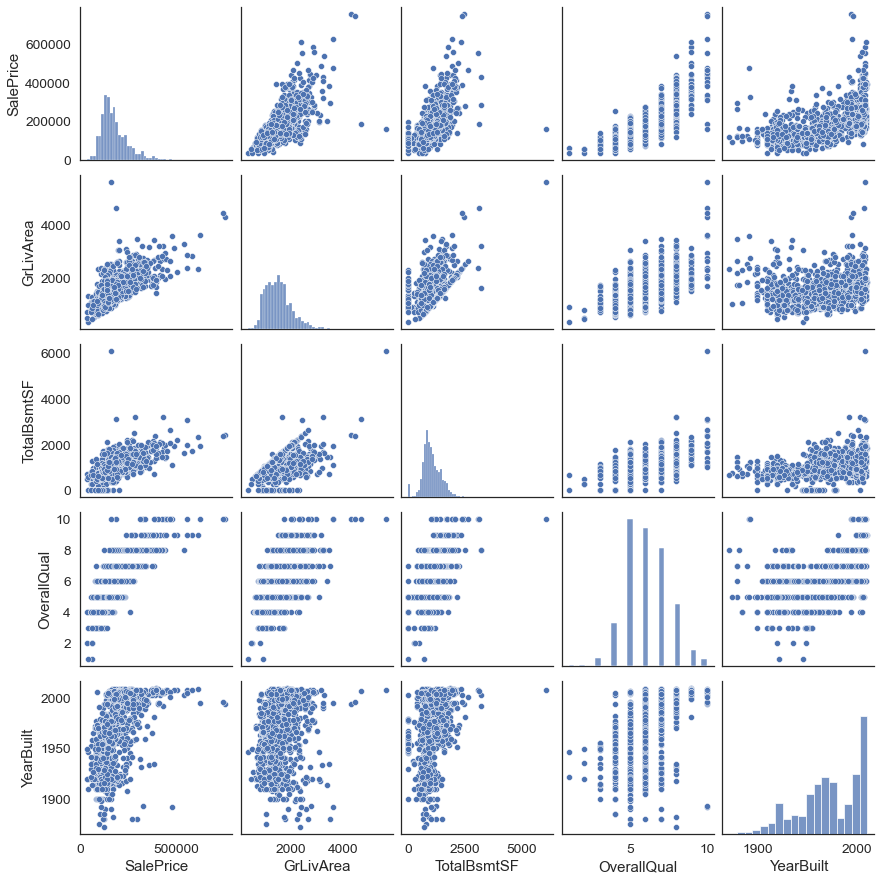

In [381]:
sns.pairplot(data=df_train[['SalePrice','GrLivArea','TotalBsmtSF','OverallQual','YearBuilt']])

As expected, the scatter plots show that all the four features have high positive correlation with SalePrice.

## Variables most correlated with 'SalePrice'

Then, let's see what other features are important for SalePrice.


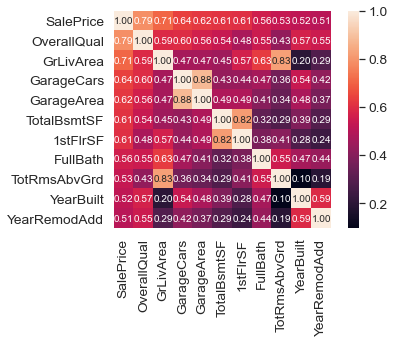

In [382]:
#saleprice correlation matrix
k = 11 #number of variables for heatmap
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

The heatmap shows top 10 features that have highest correlation with SalePrice in order. Now it's better to think all of these features add unique information for the prediction individually.

1) 'GarageCars' and 'GarageArea' are redundant features. Even though the correlations with SalesPrice are very similar, let's take 'GarageCars' which is slightly higher.  
2) 'TotalBsmtSF' and '1stFlrSF' (First Floor square feet) also seem to be redundant. Let's keep 'TotalBsmtSF'.
3) 'FullBath' (Full bathrooms above grade)  
4) 'TotRmsAbvGrd' (Total rooms above grade) and 'GrLivArea' (Above grade (ground) living area square feet) are redundant. Let's keep GrLivArea.
5) 'YearBuilt'


In [383]:
df_train.drop(['GarageArea', '1stFlrSF', 'TotRmsAbvGrd'],axis=1,inplace=True)

# Feature Engineering

## SalePrice

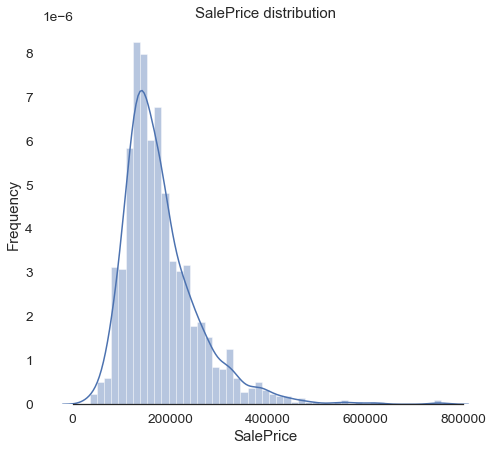

In [384]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_train['SalePrice'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

As we saw above, SalePrice feature is skewed to the right. Since most models can't deal with non-normality, I can apply a log(1+x) transfrom to make it normally distributed.

The logarithmic is a strong transformation that has a major effect on distribution shape. This technique is oftenly used for reducing right skewness.

In [385]:
# log(1+x) transform
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

Now let's see how the log transform works.


 mu = 12.02 and sigma = 0.40



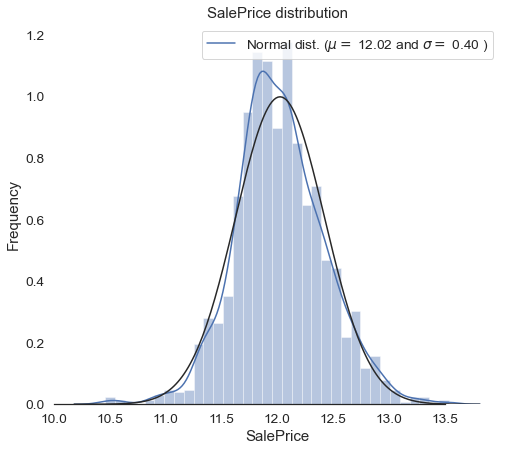

In [386]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm, color="b")

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)

plt.show()

Now SalePrice is normally distributed.

## Outliers

Let's check if there is an outliers in the features with high correlation with SalePrice. <br>
The first plot is scatter plots for top 5 features

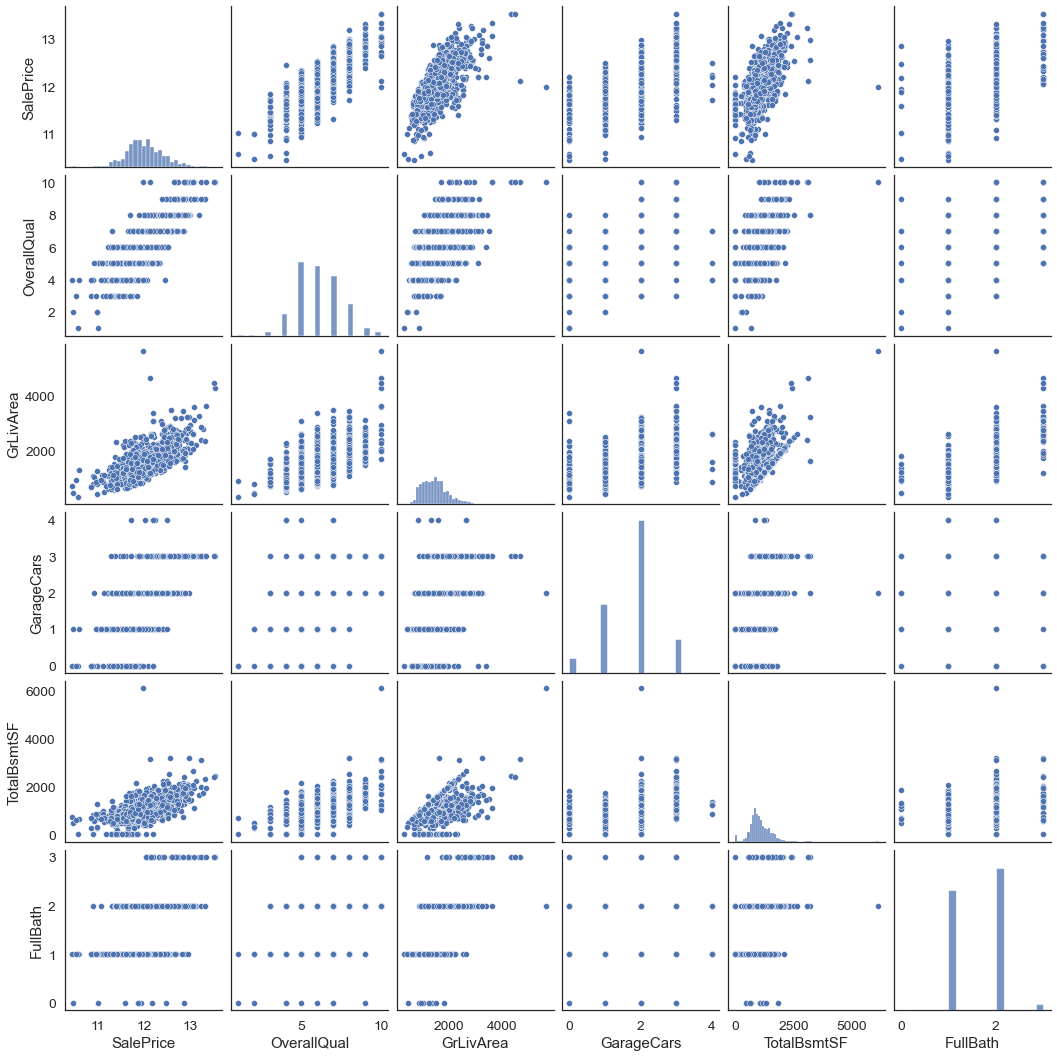

In [353]:
corrmat = df_train.corr()
cols = corrmat.nlargest(11, 'SalePrice')['SalePrice'].index
sns.pairplot(data=df_train[cols[0:6]])

Below is top 6 to 10 features.

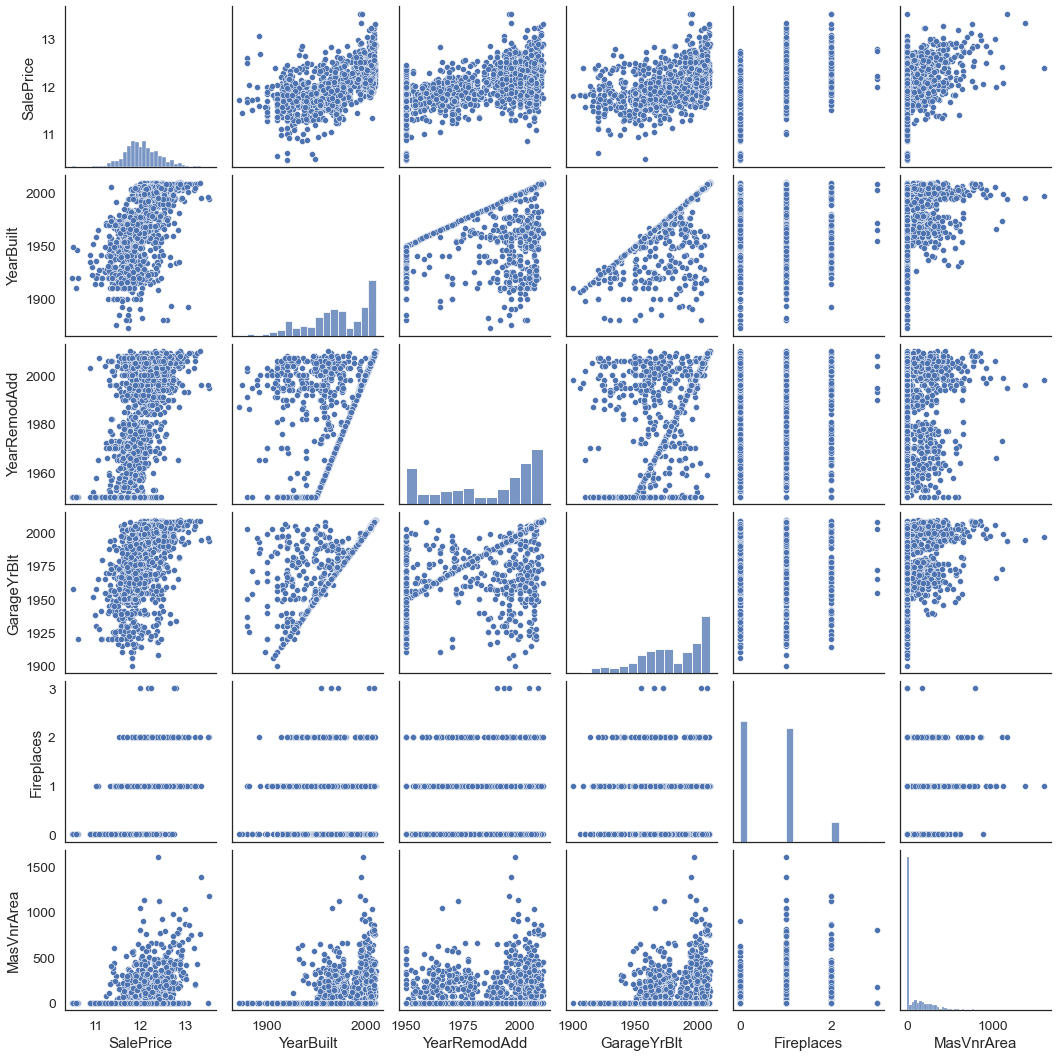

In [354]:
cols2 = cols[0:1].tolist()+cols[6:11].tolist()
sns.pairplot(data=df_train[cols2])

When we see the scatter plot between GrLivArea and SalePrice, we can easily notice that there are 2 outliers that are very different from the trend. 

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

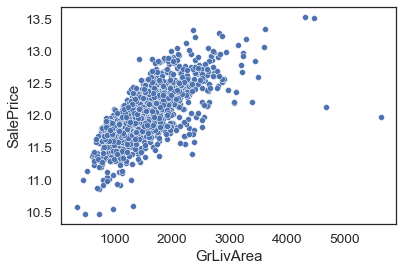

In [355]:
sns.scatterplot(data = df_train, x = 'GrLivArea', y = 'SalePrice')

As you can see, the two data points in the right are clearly outliers. Those two are very exceptional cases that might not help to predict houseprices for usual cases. Therefore, I will remove these two data points as below.

In [356]:
# Remove outliers
df_train.drop(df_train[(df_train['GrLivArea']>4500) & (df_train['SalePrice']<300000)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [357]:
df_train.shape

(1458, 77)

## Missing data

In [358]:
# Missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,99.588477
MiscFeature,1404,96.296296
Alley,1367,93.758573
Fence,1177,80.727023
FireplaceQu,690,47.325103
LotFrontage,259,17.764060
GarageCond,81,5.555556
GarageType,81,5.555556
GarageYrBlt,81,5.555556
GarageFinish,81,5.555556


There are some features with lots of missing values. I will deal with those features as below: <br><br>

1) Delete features which has more than 15% of outliers (PoolQC ~ LotFrontage) <br>
2) GarageX varaibles can be replaced with GarageCars which has high correlation with SalePrice <br>
3) MasVnrType and MasVnrArea can explained by OverallQual <br>
4) Electrical should be kept and only has 1 missing record. The missing record will be just dropped.

In [359]:
#dealing with missing data
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

0

In [360]:
df_train.isnull().sum().head(10)

MSSubClass      0
MSZoning        0
LotArea         0
Street          0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
dtype: int64

Now there is no missing value in the training data set.

In [361]:
# One non-numeric predictor is stored as numbers; convert them into strings 
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)


Then, let's see missing values for test data set.

In [362]:
# Missing data
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageCond,78,5.346127
GarageQual,78,5.346127
GarageYrBlt,78,5.346127
GarageFinish,78,5.346127


Since we don't have no particular intuition about how to fill the missing values for catergorical features, we're going to replace those with None. We will replace the missing values for numerical values with 0.

In [363]:
def handle_missing(features):
    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

df_test = handle_missing(df_test)

Let's split the train data into features and label. We're going to combine train features and test features to apply the fature transformation process to the entire data.

In [364]:
# Split features and labels
train_y = df_train['SalePrice'].reset_index(drop=True)
train_X = df_train.drop(['SalePrice'], axis=1)

# Exclude features that are dropped from training data
commonlabel=[x for x in df_train.columns if x in df_test.columns]
test_X = df_test[commonlabel]

# Combine df_train and test features in order to apply the feature transformation pipeline to the entire dataset
df_all = pd.concat([train_features, test_X]).reset_index(drop=True)
df_all.shape

(2916, 61)

## Fix Skewness in numeric features

Let's find the numeric features which are not normally distributed and fix those.

In [365]:
# Extract name of numeric features
numeric=df_all.dtypes[df_all.dtypes!='object'].index.tolist()

We can see the distribution of numeric features using box plot.

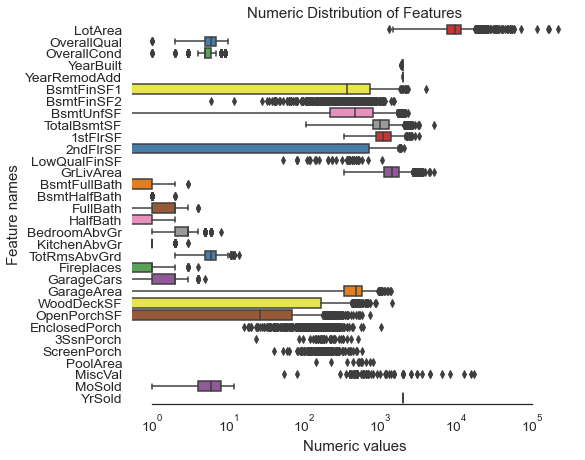

In [366]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=df_all[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [367]:
# Find skewed numerical features
skew_features = df_all[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5] # When skewness is higher than 0.5, it is considered non-normality
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 21 numerical features with Skew > 0.5 :


MiscVal          21.935910
PoolArea         17.685603
LotArea          13.107212
LowQualFinSF     12.082427
3SsnPorch        11.370087
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
dtype: float64

These 18 features are considered having highly skewed.

Applying Box-Cox transformation will allow us to normalize those 18 features.

The Box-Cox transformation is, as you probably understand, also a technique to transform non-normal data into normal shape. This is a procedure to identify a suitable exponent (Lambda = l) to use to transform skewed data.

In [388]:
# Normalize skewed features
for i in skew_index:
    df_all[i] = boxcox1p(df_all[i], boxcox_normmax(df_all[i] + 1))

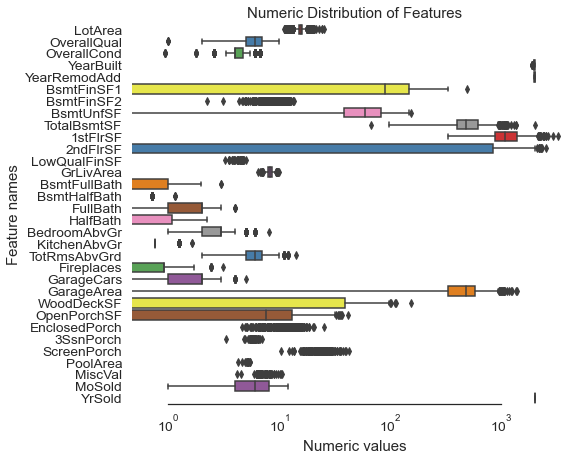

In [389]:
# Create box plots for all numeric features
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=df_all[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

## Encode categotical variables

Using one hot encoding, we can encode categorical features that can be fed into machine learning models.

In [369]:
# one hot encoding for categorical features
df_all = pd.get_dummies(df_all).reset_index(drop=True)
df_all.shape

(2916, 256)

## Save data
Let's split data into train and test data again and save the data for the following modeling process.

In [370]:
# Split concatenated data
train_X = df_all.iloc[:len(train_y), :]
test_X = df_all.iloc[len(train_y):, :]
X.shape, train_y.shape, test_X.shape

((1457, 285), (1457,), (1459, 256))

In [371]:
# Save processed data
train_X.to_csv('../data/processed/train_X.csv',index=False)
train_y.to_csv('../data/processed/train_y.csv',index=False)
test_X.to_csv('../data/processed/test_X.csv',index=False)